In [1]:
##
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
##
import numpy as np
import pandas as pd
import datetime as dt
#added Path
from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [3]:
## Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
#added text
from sqlalchemy import create_engine, func, text

In [4]:
hawaii_database_path = Path("../resources/hawaii.sqlite")

## create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{hawaii_database_path}").connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#added inspect 
from sqlalchemy import inspect

print(engine.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall())

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]


In [10]:
#get list of column names and types for MEASUREMENT
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#get list of column names and types for STATION
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#view measurement table 
data = pd.read_sql("select * from measurement", engine)
data.head()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [13]:
#view measurement table 
data = pd.read_sql("select * from measurement", engine)
data.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


In [14]:
#view station table 
data = pd.read_sql("select * from station", engine)
data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [15]:
#view station table 
data = pd.read_sql("select * from station", engine)
data.tail()

,id,station,name,latitude,longitude,elevation
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [18]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()[0]
print(most_recent_date)
print(type(most_recent_date))

2017-08-23
<class 'str'>


            date  precipitation
0     2016-08-24           0.08
1     2016-08-24           2.15
2     2016-08-24           2.28
3     2016-08-24            NaN
4     2016-08-24           1.22
...          ...            ...
2218  2017-08-22           0.50
2221  2017-08-23           0.08
2219  2017-08-23           0.00
2220  2017-08-23           0.00
2222  2017-08-23           0.45

[2223 rows x 2 columns]


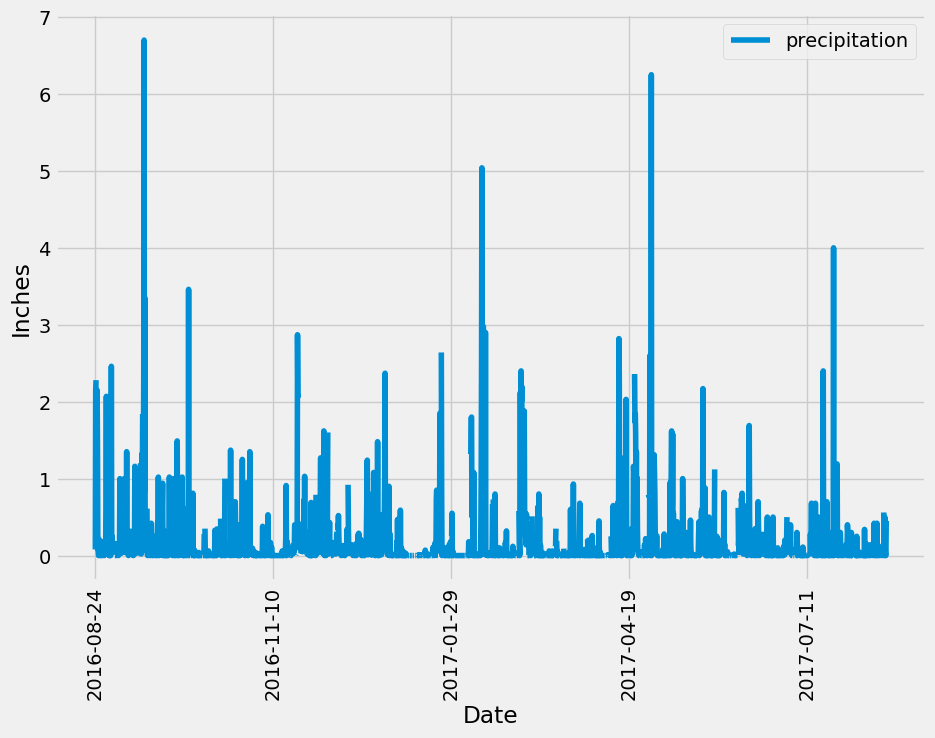

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#convert string to datetime object
# Calculate the date one year from the last date in data set.
#one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores -- using one_year_ago 
precip_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precp_by_date_df = pd.DataFrame(precip_scores, columns = ["date", "precipitation"])

# Sort the dataframe by date
precp_by_date_df = precp_by_date_df.sort_values("date")
print(precp_by_date_df)

# Use Pandas Plotting with Matplotlib to plot the data #
precp_by_date_df.plot(x="date", y="precipitation", rot= 90, figsize=(10,7))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data

precp_by_date_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

print(f"There are {total_stations} stations in the dataset")


There are 9 stations in the dataset


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    
most_active_stations   

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Answer the following question: which station id has the greatest number of observations?
Station with the greatest number of observations: USC00519281

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station, func.count(Measurement.station))\
        .group_by(Measurement.station)\
        .order_by(func.count(Measurement.station).desc())\
        .first()

#extract the station ID from the tuple
most_active_station_id = most_active[0]

temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs) 
    ).filter(Measurement.station == most_active_station_id).all()

temp_stats

[(54.0, 85.0, 71.66378066378067)]

In [24]:
print(
        f"The station with the greatest number of observations: '{most_active_station_id}'")


The station with the greatest number of observations: 'USC00519281'


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#extract the min, max, avg values to format as a string
min_temp, max_temp, avg_temp = temp_stats[0]

#print result into a string (option + shift + 8 = °)
temp_summary = (
f"The temperature stats for {most_active_station_id} are:\n"
f"Lowest Temperature: {min_temp}°F\n"
f"Higest Temperature: {max_temp}°F\n"
f"Average Temperature: {avg_temp:.1f}°F\n"
)

print(temp_summary)

The temperature stats for USC00519281 are:
Lowest Temperature: 54.0°F
Higest Temperature: 85.0°F
Average Temperature: 71.7°F



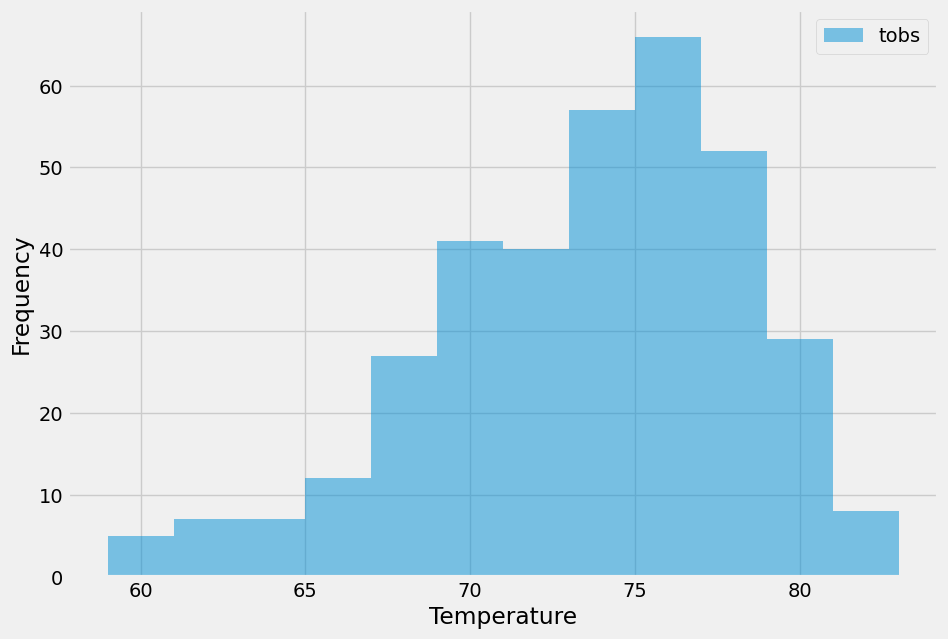

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()
    
temp_obs

temp_by_date_df = pd.DataFrame(temp_obs, columns = ["date", "tobs"])

temp_by_date_df["tobs"].plot.hist(bins=12, alpha = 0.5, figsize=(10,7))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [27]:
## Close Session
session.close()